In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas as pd
import detection as dtc
import fitting
import emission
from constants import *
import cross_sections as cs
from scipy.interpolate import interp1d
from math import gamma
from scipy.integrate import simps
from tqdm import tqdm


Bad key text.latex.preview in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
E = np.linspace(1e-3, 100, 1000000) # Neutrino detection energy
detector = 'super-k'
resolution = 0.05 # Fraction of error in energy reconstruction
distance = 5 # kpc
targets = (32e9/18.01528)*6.022e23*2

In [55]:
E_mean_nubar_e = 13.82 # Garching group simulations
alpha_nubar_e = 2.47 # Garching group simulations
E_mean_nu_e = 11.06 # Garching group simulations
alpha_nu_e = 2.76 # Garching group simulations
E_mean_nu_x = 13.76 # Garching group simulations
alpha_nu_x = 2.07 # Garching group simulations

## Functions

In [6]:
def produced_spectrum(x, alpha, E_mean, E_tot):
    L = E_tot*6.2415e5
    A = L*((1+alpha)**(1+alpha))/((gamma(1+alpha))*E_mean**(2+alpha))
    f_nu = A*(x**alpha)*np.exp(-(alpha + 1)*x/E_mean)
    return f_nu

In [10]:
def emitted_spectrum(x, alpha_nue, E_mean_nue, alpha_nubare, E_mean_nubare,
                     alpha_nux, E_mean_nux, E_tot, flavor = 'nu_e', hierarchy = 'normal'):
    F_e = produced_spectrum(x, alpha_nue, E_mean_nue, E_tot)
    F_ebar = produced_spectrum(x, alpha_nubare, E_mean_nubare, E_tot)
    F_x = produced_spectrum(x, alpha_nux, E_mean_nux, E_tot)
    if hierarchy == 'normal':
        a_e = s_12**2
        b_e = 0
        c_e = c_12**2
        a_ebar = 0
        b_ebar = 0
        c_ebar = 1
        a_x = 0.25*(2 + s_12**2)
        b_x = 0.25
        c_x = 0.25*c_12**2
    elif hierarchy == 'inverted':
        a_e = 0
        b_e = 0
        c_e = 1
        a_ebar = 0
        b_ebar = c_12**2
        c_ebar = s_12**2
        a_x = 0.25*(2 + c_12**2)
        b_x = 0.25
        c_x = 0.25*s_12**2
    else:
        raise ValueError('Invalid type of hierarchy, please use "normal" or "inverted"')
    if flavor == 'nu_e':
        return a_e*F_e + b_e*F_ebar + c_e*F_x
    elif flavor == 'nubar_e':
        return a_ebar*F_e + b_ebar*F_ebar + c_ebar*F_x + (F_ebar - F_x)
    elif flavor == 'nu_x':
        return a_x*F_e + b_x*F_ebar + c_x*F_x
    else:
        raise ValueError('Invalid entry for neutrino species. Please use "nu_e" for \
                electron neutrinos, "nubar_e" for electron antineutrinos or "nu_x" for mu or \
                tau (anti)neutrinos')

In [14]:
def detection_spectra(x, alpha_nue, E_mean_nue, alpha_nubare, E_mean_nubare,
                     alpha_nux, E_mean_nux, E_tot, flavor = 'nu_e', detector = 'super-k',
                    hierarchy = 'normal', distance = 10):
    if detector == 'super-k':
        channels = ['ibd','nue_e','nuebar_e','nue_O16','nuebar_O16','numu_e',
                    'numubar_e','nc_nue_O16','nc_nuebar_O16']
        xs_data = cs.snowglobes(channels)
        
        # All these cross sections are in units of 10⁻³⁸ cm²/MeV
        cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
        cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
        cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
        cs_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
        cs_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
        cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
        cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
        cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
        cs_nc_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
        # Number of target particles
        n_target = (32e9/18.01528)*6.022e23*2 # number of protons
        # Total cross section
        if flavor == 'nu_e':
            total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_O16(x)*x*1e-38 + cs_nc_nue_O16(x)*x*1e-38
        elif flavor == 'nubar_e':
            total_cross = cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_O16(x)*x*1e-38 + cs_nc_nuebar_O16(x)*x*1e-38
        elif flavor == 'nu_x':
            total_cross = cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38
        else:
            raise ValueError('Invalid entry for neutrino species. Please use "nu_e" for \
                electron neutrinos, "nubar_e" for electron antineutrinos or "nu_x" for mu or \
                tau (anti)neutrinos')
        # Detector efficiency
        eff = dtc.efficiency_sigmoid(x, 1, 7, 3.5)
    elif detector == 'DUNE':
        channels = ['ibd','nue_e','nuebar_e','nue_Ar40','nuebar_Ar40','numu_e',
                    'numubar_e','nc_nue_Ar40','nc_nuebar_Ar40','nc_numu_Ar40',
                    'nc_numubar_Ar40']
        xs_data = cs.snowglobes(channels)

        # All these cross sections are in units of 10⁻³⁸ cm²/MeV
        cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
        cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
        cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
        cs_nue_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
        cs_nuebar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
        cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
        cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
        cs_nc_nue_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
        cs_nc_nuebar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
        cs_nc_nux_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[9][2]/1e3, fill_value='extrapolate')
        cs_nc_nuxbar_Ar40 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[10][5]/1e3, fill_value='extrapolate')
        # Number of target particles
        n_target = 6.03e32
        # Total cross section
        if flavor == 'nu_e':
            total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_Ar40(x)*x*1e-38 + cs_nc_nue_Ar40(x)*x*1e-38
        elif flavor == 'nubar_e':
            total_cross = cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_Ar40(x)*x*1e-38 + cs_nc_nuebar_Ar40(x)*x*1e-38
        elif flavor == 'nu_x':
            total_cross = cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nux_Ar40(x)*x*1e-38 + cs_nc_nuxbar_Ar40(x)*x*1e-38
        else:
            raise ValueError('Invalid entry for neutrino species. Please use "nu_e" for \
                electron neutrinos, "nubar_e" for electron antineutrinos or "nu_x" for mu or \
                tau (anti)neutrinos')
        # Detector efficiency
        eff = dtc.efficiency_sigmoid(x, 0.98, 1.2127, 8.0591)
    elif detector == 'JUNO':
        channels = ['ibd','nue_e','nuebar_e','nue_C12','nuebar_C12','numu_e',
                    'numubar_e','nc_nue_C12','nc_nuebar_C12','nc_numu_C12',
                    'nc_numubar_C12']
        xs_data = cs.snowglobes(channels)

        # All these cross sections are in units of 10⁻³⁸ cm²/MeV
        cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value = (0,xs_data[0][1][-1]/1e3))
        cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value = (0,xs_data[1][1][-1]/1e3))
        cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value = (0,xs_data[2][4][-1]/1e3))
        cs_nue_C12 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value = (0,xs_data[3][1][-1]/1e3))
        cs_nuebar_C12 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value = (0,xs_data[4][1][-1]/1e3))
        cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value = (0,xs_data[5][2][-1]/1e3))
        cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value = (0,xs_data[6][5][-1]/1e3))
        cs_nc_nue_C12 = interp1d(1e3*(10**(xs_data[7][0])), xs_data[7][1]/1e3, fill_value = 'extrapolate')
        cs_nc_nuebar_C12 = interp1d(1e3*(10**(xs_data[8][0])), xs_data[8][4]/1e3, fill_value = 'extrapolate')
        cs_nc_nux_C12 = interp1d(1e3*(10**(xs_data[9][0])), xs_data[9][2]/1e3, fill_value = 'extrapolate')
        cs_nc_nuxbar_C12 = interp1d(1e3*(10**(xs_data[10][0])), xs_data[10][5]/1e3, fill_value = 'extrapolate')
        # Number of target particles
        """"
        Fengpeng, A., Guangpeng, A. N., Qi, A. N., Antonelli, V., Baussan, E.,
        Beacom, J., ... & Sinev, V. (2016). Neutrino physics with JUNO.
        """
        n_target = 1.5e33
        # Total cross section
        if flavor == 'nu_e':
            total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_C12(x)*x*1e-38 + cs_nc_nue_C12(x)*x*1e-38
        elif flavor == 'nubar_e':
            total_cross = cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_C12(x)*x*1e-38 + cs_nc_nuebar_C12(x)*x*1e-38
        elif flavor == 'nu_x':
            total_cross = cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38 + cs_nc_nux_C12(x)*x*1e-38 + cs_nc_nuxbar_C12(x)*x*1e-38
        else:
            raise ValueError('Invalid entry for neutrino species. Please use "nu_e" for \
                electron neutrinos, "nubar_e" for electron antineutrinos or "nu_x" for mu or \
                tau (anti)neutrinos')
        # Detector efficiency
        eff = np.where(x<1,0,1) #efficiency_sigmoid(x, 0.918, 1.2127, 3)
    elif detector == 'Hyper-k':
        channels = ['ibd','nue_e','nuebar_e','nue_O16','nuebar_O16','numu_e',
                    'numubar_e','nc_nue_O16']
        xs_data = cs.snowglobes(channels)

        # All these cross sections are in units of 10⁻³⁸ cm²/MeV
        cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
        cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
        cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
        cs_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
        cs_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
        cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
        cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
        cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
        # Number of target particles
        n_target = (216e9/18.01528)*6.022e23*2 # number of protons
        # Total cross section
        if flavor == 'nu_e':
            total_cross = cs_nue_e(x)*x*1e-38 + cs_nue_O16(x)*x*1e-38 + cs_nc_nue_O16(x)*x*1e-38
        elif flavor == 'nubar_e':
            total_cross = cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_O16(x)*x*1e-38
        elif flavor == 'nu_x':
            total_cross = cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38
        else:
            raise ValueError('Invalid entry for neutrino species. Please use "nu_e" for \
                electron neutrinos, "nubar_e" for electron antineutrinos or "nu_x" for mu or \
                tau (anti)neutrinos')
        # Detector efficiency
        eff = np.where(x<3,0,0.9) #efficiency_sigmoid(x, 0.918, 1.2127, 3)
    else:
        raise ValueError("Ops, we don't have this detector in our simulations. Try 'super-k', \
            'Hyper-k', 'DUNE' or 'JUNO'.")
    # Normalization
    distance_cm = distance*3.086e21 #conversion from kiloparsec to centimeter
    A = n_target/(4 * np.pi * distance_cm**2)
    # Emission spectrum
    spectrum = emitted_spectrum(x, alpha_nue, E_mean_nue, alpha_nubare, E_mean_nubare,
                     alpha_nux, E_mean_nux, E_tot, flavor, hierarchy)
    return A*spectrum*total_cross*eff

## Test

In [18]:
dtc_nu_e = detection_spectra(E, alpha_nu_e, E_mean_nu_e,
                      alpha_nubar_e, E_mean_nubar_e, alpha_nu_x,
                      E_mean_nu_x, 5e52, flavor = 'nu_e', detector = detector,
                     hierarchy = 'normal', distance = distance)
dtc_nubar_e = detection_spectra(E, alpha_nu_e, E_mean_nu_e,
                      alpha_nubar_e, E_mean_nubar_e, alpha_nu_x,
                      E_mean_nu_x, 5e52, flavor = 'nubar_e', detector = detector,
                     hierarchy = 'normal', distance = distance)
dtc_nu_x = detection_spectra(E, alpha_nu_e, E_mean_nu_e,
                      alpha_nubar_e, E_mean_nubar_e, alpha_nu_x,
                      E_mean_nu_x, 5e52, flavor = 'nu_x', detector = detector,
                     hierarchy = 'normal', distance = distance)

(0.0, 100.0)

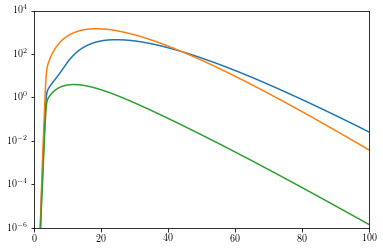

In [19]:
plt.plot(E, dtc_nu_e)
plt.plot(E, dtc_nubar_e)
plt.plot(E, dtc_nu_x)
plt.yscale('log')
plt.ylim(1e-6, 1e4)
plt.xlim(0, 100)

In [20]:
emit_nu_e = emitted_spectrum(E, alpha_nu_e, E_mean_nu_e, alpha_nubar_e, E_mean_nubar_e,
                     alpha_nu_x, E_mean_nu_x, 5e52, 'nu_e', hierarchy = 'normal')
emit_nubar_e = emitted_spectrum(E, alpha_nu_e, E_mean_nu_e, alpha_nubar_e, E_mean_nubar_e,
                     alpha_nu_x, E_mean_nu_x, 5e52, 'nubar_e', hierarchy = 'normal')
emit_nu_x = emitted_spectrum(E, alpha_nu_e, E_mean_nu_e, alpha_nubar_e, E_mean_nubar_e,
                     alpha_nu_x, E_mean_nu_x, 5e52, 'nu_x', hierarchy = 'normal')

(0.0, 80.0)

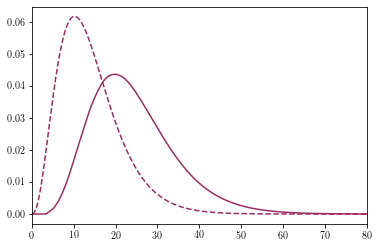

In [69]:
plt.plot(E, (dtc_nu_e+dtc_nubar_e+dtc_nu_x)/simps(dtc_nu_e+dtc_nubar_e+dtc_nu_x, E),
         color = sns.color_palette('inferno')[2])
plt.plot(E, (emit_nu_e+emit_nubar_e+emit_nu_x)/simps(emit_nu_e+emit_nubar_e+emit_nu_x,E),
         color = sns.color_palette('inferno')[2],
        ls = '--')
# plt.plot(E, dtc_nubar_e/simps(dtc_nubar_e, E), color = sns.color_palette('inferno')[0])
# plt.plot(E, emit_nubar_e/simps(emit_nubar_e,E), color = sns.color_palette('inferno')[0],
#         ls = '--')
# plt.plot(E, dtc_nu_x/simps(dtc_nu_x, E), color = sns.color_palette('inferno')[4])
# plt.plot(E, emit_nu_x/simps(emit_nu_x,E), color = sns.color_palette('inferno')[4],
#         ls = '--')
plt.xlim(0, 80)

In [22]:
E_mean_dtc_nu_e = simps(dtc_nu_e*E, E)/simps(dtc_nu_e, E)
E_mean_emit_nu_e = simps(emit_nu_e*E, E)/simps(emit_nu_e, E)
E_mean_dtc_nubar_e = simps(dtc_nubar_e*E, E)/simps(dtc_nubar_e, E)
E_mean_emit_nubar_e = simps(emit_nubar_e*E, E)/simps(emit_nubar_e, E)
E_mean_dtc_nu_x = simps(dtc_nu_x*E, E)/simps(dtc_nu_x, E)
E_mean_emit_nu_x = simps(emit_nu_x*E, E)/simps(emit_nu_x, E)

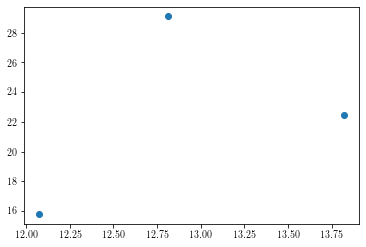

In [23]:
plt.scatter([E_mean_emit_nu_e,E_mean_emit_nubar_e,
             E_mean_emit_nu_x], [E_mean_dtc_nu_e,E_mean_dtc_nubar_e,
                                 E_mean_dtc_nu_x])

In [63]:
mean_energy_dtc_nubar_e = []
mean_energy_emit_nubar_e = []
alphas_nubar_e = []
mean_energy_nubar_e = np.zeros((21,21))
mean_energy_nubar_e_ratio = np.zeros((21,21))
for i in tqdm(range(21)):
    E_mean_nubar_e = 9 + 0.25*i
    for j in range(21):
        alpha_nubar_e = 1 + 0.1*j
        alphas_nubar_e.append(alpha_nubar_e)
        dtc_nu_e = detection_spectra(E, alpha_nu_e, E_mean_nu_e,
                          alpha_nubar_e, E_mean_nubar_e, alpha_nu_x,
                          E_mean_nu_x, 5e52, flavor = 'nu_e', detector = detector,
                         hierarchy = 'normal', distance = distance)
        dtc_nubar_e = detection_spectra(E, alpha_nu_e, E_mean_nu_e,
                              alpha_nubar_e, E_mean_nubar_e, alpha_nu_x,
                              E_mean_nu_x, 5e52, flavor = 'nubar_e', detector = detector,
                             hierarchy = 'normal', distance = distance)
        dtc_nu_x = detection_spectra(E, alpha_nu_e, E_mean_nu_e,
                              alpha_nubar_e, E_mean_nubar_e, alpha_nu_x,
                              E_mean_nu_x, 5e52, flavor = 'nu_x', detector = detector,
                             hierarchy = 'normal', distance = distance)
        emit_nu_e = emitted_spectrum(E, alpha_nu_e, E_mean_nu_e, alpha_nubar_e, E_mean_nubar_e,
                         alpha_nu_x, E_mean_nu_x, 5e52, 'nu_e', hierarchy = 'normal')
        emit_nubar_e = emitted_spectrum(E, alpha_nu_e, E_mean_nu_e, alpha_nubar_e, E_mean_nubar_e,
                             alpha_nu_x, E_mean_nu_x, 5e52, 'nubar_e', hierarchy = 'normal')
        emit_nu_x = emitted_spectrum(E, alpha_nu_e, E_mean_nu_e, alpha_nubar_e, E_mean_nubar_e,
                             alpha_nu_x, E_mean_nu_x, 5e52, 'nu_x', hierarchy = 'normal')
        mean_energy_dtc_nubar_e.append(simps(dtc_nubar_e*E, E)/simps(dtc_nubar_e, E))
        mean_energy_nubar_e[i,j] = simps(dtc_nubar_e*E, E)/simps(dtc_nubar_e, E)
        mean_energy_nubar_e_ratio[i,j] = (simps(dtc_nubar_e*E, E)/simps(dtc_nubar_e, E))/(simps(emit_nubar_e*E, E)/simps(emit_nubar_e, E))
        mean_energy_emit_nubar_e.append(simps(emit_nubar_e*E, E)/simps(emit_nubar_e, E))

100%|██████████| 21/21 [15:18<00:00, 43.75s/it]


In [64]:
nubar_e = pd.DataFrame({'Alpha': alphas_nubar_e,
           'E_mean_dtc': mean_energy_dtc_nubar_e,
           'E_mean_emit': mean_energy_emit_nubar_e})

(9.0, 30.0)

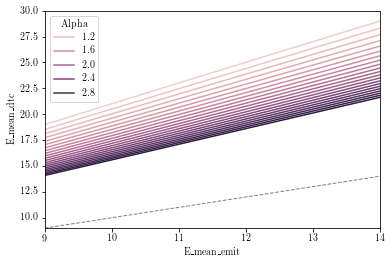

In [65]:
sns.lineplot(data = nubar_e, x = 'E_mean_emit', y = 'E_mean_dtc', hue = 'Alpha')
plt.plot(mean_energy_emit_nubar_e, mean_energy_emit_nubar_e, lw = 1,
         ls = '--', color = 'grey')
plt.xlim(9, 14)
plt.ylim(9, 30)

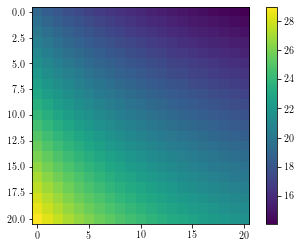

In [66]:
plt.imshow(mean_energy_nubar_e)
plt.colorbar()

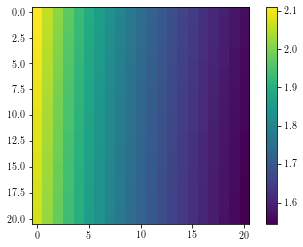

In [67]:
plt.imshow(mean_energy_nubar_e_ratio)
plt.colorbar()

In [ ]:
plt.contourf(mean_energy_nubar_e, levels = 20)

In [61]:
mean_energy_emit_nu_e = []
mean_energy_emit_nu_x = []
mean_energy_dtc_nubar_e = []
alphas_nubar_e = []
mean_energy_nubar_e = np.zeros((21,21))
mean_energy_nubar_e_ratio = np.zeros((21,21))
for i in tqdm(range(21)):
    E_mean_nu_e = 9 + 0.25*i
    mean_energy_emit_nu_e.append(E_mean_nu_e)
    for j in range(21):
        E_mean_nu_x = 9 + 0.25*i
        mean_energy_emit_nu_x.append(alpha_nubar_e)
        dtc_nu_e = detection_spectra(E, alpha_nu_e, E_mean_nu_e,
                          alpha_nubar_e, E_mean_nubar_e, alpha_nu_x,
                          E_mean_nu_x, 5e52, flavor = 'nu_e', detector = detector,
                         hierarchy = 'normal', distance = distance)
        dtc_nubar_e = detection_spectra(E, alpha_nu_e, E_mean_nu_e,
                              alpha_nubar_e, E_mean_nubar_e, alpha_nu_x,
                              E_mean_nu_x, 5e52, flavor = 'nubar_e', detector = detector,
                             hierarchy = 'normal', distance = distance)
        dtc_nu_x = detection_spectra(E, alpha_nu_e, E_mean_nu_e,
                              alpha_nubar_e, E_mean_nubar_e, alpha_nu_x,
                              E_mean_nu_x, 5e52, flavor = 'nu_x', detector = detector,
                             hierarchy = 'normal', distance = distance)
        emit_nu_e = emitted_spectrum(E, alpha_nu_e, E_mean_nu_e, alpha_nubar_e, E_mean_nubar_e,
                         alpha_nu_x, E_mean_nu_x, 5e52, 'nu_e', hierarchy = 'normal')
        emit_nubar_e = emitted_spectrum(E, alpha_nu_e, E_mean_nu_e, alpha_nubar_e, E_mean_nubar_e,
                             alpha_nu_x, E_mean_nu_x, 5e52, 'nubar_e', hierarchy = 'normal')
        emit_nu_x = emitted_spectrum(E, alpha_nu_e, E_mean_nu_e, alpha_nubar_e, E_mean_nubar_e,
                             alpha_nu_x, E_mean_nu_x, 5e52, 'nu_x', hierarchy = 'normal')
        mean_energy_dtc_nubar_e.append(simps(dtc_nubar_e*E, E)/simps(dtc_nubar_e, E))
        mean_energy_nubar_e[i,j] = simps(dtc_nubar_e*E, E)/simps(dtc_nubar_e, E)
        mean_energy_nubar_e_ratio[i,j] = (simps(dtc_nubar_e*E, E)/simps(dtc_nubar_e, E))/(simps(emit_nubar_e*E, E)/simps(emit_nubar_e, E))

100%|██████████| 21/21 [14:30<00:00, 41.44s/it]


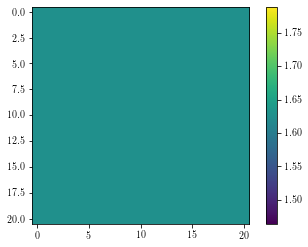

In [62]:
plt.imshow(mean_energy_nubar_e_ratio)
plt.colorbar()